<a href="https://colab.research.google.com/github/BySwesh/DerinOgrenme/blob/main/Resnet50v-Gradient%20Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import os

In [3]:
data_dir = '/content/drive/MyDrive/Retinal Imaging/Eyes/'

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(len(os.listdir(data_dir)), activation='softmax')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [11]:
image_paths = []
labels = []

In [12]:
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(class_name)

In [13]:
data_df = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data_df['image_path'], data_df['label'], test_size=0.2, random_state=42)

In [15]:
features_train = []
features_test = []

In [16]:
for img_path in X_train:
    img = image.load_img(img_path, target_size=(50, 50))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    features = model.predict(img_array)
    features_train.append(features.flatten())

1/1 [==============================] - 0s 71ms/step


In [17]:
for img_path in X_test:
    img = image.load_img(img_path, target_size=(50, 50))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    features = model.predict(img_array)
    features_test.append(features.flatten())

1/1 [==============================] - 0s 74ms/step


In [18]:
gb_model = GradientBoostingClassifier()
gb_model.fit(features_train, y_train)

GradientBoostingClassifier()

In [19]:
y_pred = gb_model.predict(features_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.38797169811320753

Classification Report:
                       precision    recall  f1-score   support

            Cataract       0.42      0.55      0.47       198
Diabetic Retinopathy       0.45      0.45      0.45       238
            Glaucoma       0.21      0.17      0.19       175
              Normal       0.39      0.36      0.38       237

            accuracy                           0.39       848
           macro avg       0.37      0.38      0.37       848
        weighted avg       0.38      0.39      0.38       848



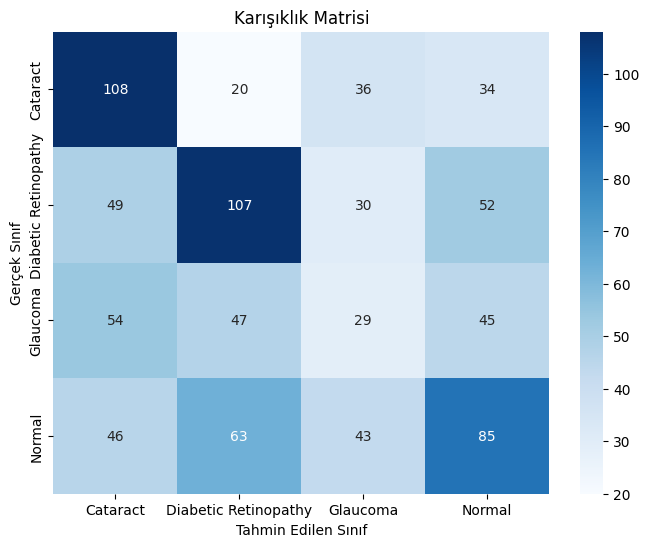

In [21]:
cm = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=gb_model.classes_, yticklabels=gb_model.classes_)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karışıklık Matrisi')
plt.show()